In [8]:
import os # Operating System
import numpy as np
import pandas as pd
import datetime as dt # Datetime
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium #import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [9]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [10]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [11]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [12]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [13]:
new_york_data=get_new_york_data()

In [14]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
new_york_data.shape

(306, 4)

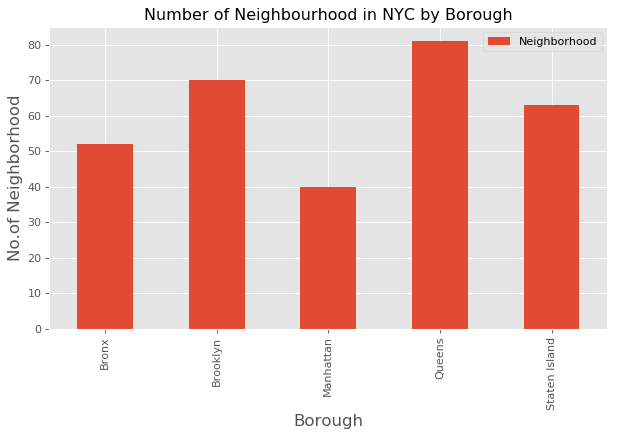

In [16]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [17]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:1
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [18]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Williamsbridge,570c3a3fcd10eecd0d0434cd,Agra Grill
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [19]:
indian_rest_ny.shape

(143, 4)

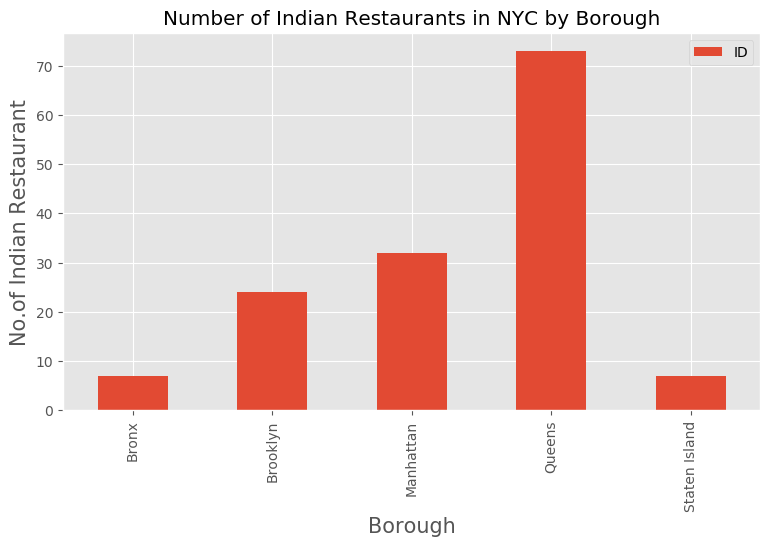

In [20]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [21]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
108,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


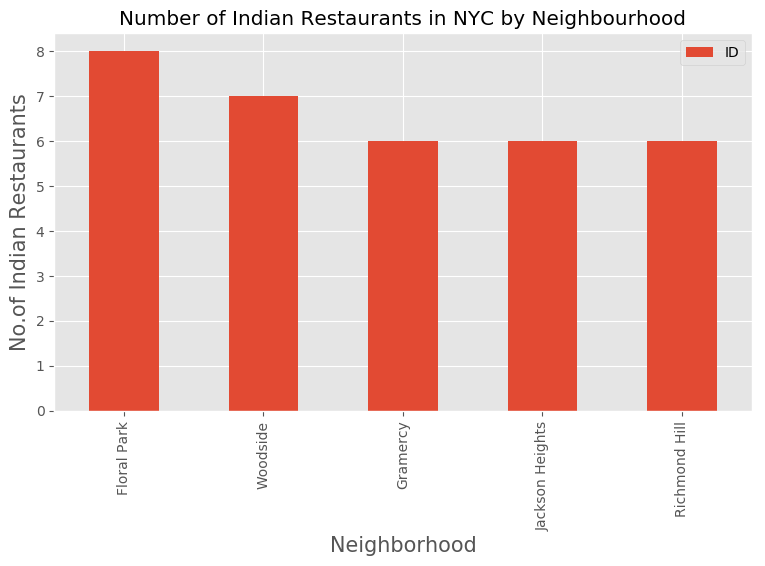

In [22]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [23]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 4c0448d9310fc9b6bf1dc761
( 1 / 143 ) processed
No data available for id= 570c3a3fcd10eecd0d0434cd
( 2 / 143 ) processed
No data available for id= 4c194631838020a13e78e561
( 3 / 143 ) processed
No data available for id= 4c04544df423a593ac83d116
( 4 / 143 ) processed
No data available for id= 551b7f75498e86c00a0ed2e1
( 5 / 143 ) processed
No data available for id= 4c194631838020a13e78e561
( 6 / 143 ) processed
No data available for id= 4b5a4dc8f964a520a2bb28e3
( 7 / 143 ) processed
No data available for id= 545835a1498e820edc6f636f
( 8 / 143 ) processed
No data available for id= 4af0d31bf964a5207ddf21e3
( 9 / 143 ) processed
No data available for id= 52213c4211d295d4c57a607c
( 10 / 143 ) processed
No data available for id= 564d283d498e6e851df79d87
( 11 / 143 ) processed
No data available for id= 512a9ea9e4b004fb8eeb84e5
( 12 / 143 ) processed
No data available for id= 4db0f4371e729fcc56497f20
( 13 / 143 ) processed
No data available for id= 4b718914f964a520c04b2

In [24]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,0,0,0,0,0
1,Bronx,Williamsbridge,0,0,0,0,0
2,Bronx,Parkchester,0,0,0,0,0
3,Bronx,Spuyten Duyvil,0,0,0,0,0
4,Bronx,Concourse,0,0,0,0,0


In [25]:
indian_rest_stats_ny.shape

(143, 7)

In [26]:
indian_rest_ny.shape

(143, 4)

In [27]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [28]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [29]:
indian_rest_stats_ny_csv.shape

(143, 7)

In [30]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,0,0,0,0,0
1,Bronx,Williamsbridge,0,0,0,0,0
2,Bronx,Parkchester,0,0,0,0,0
3,Bronx,Spuyten Duyvil,0,0,0,0,0
4,Bronx,Concourse,0,0,0,0,0


In [31]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
Borough         143 non-null object
Neighborhood    143 non-null object
ID              143 non-null object
Name            143 non-null object
Likes           143 non-null object
Rating          143 non-null object
Tips            143 non-null object
dtypes: object(7)
memory usage: 7.9+ KB


In [32]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [33]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [34]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
Borough         143 non-null object
Neighborhood    143 non-null object
ID              143 non-null object
Name            143 non-null object
Likes           143 non-null float64
Rating          143 non-null object
Tips            143 non-null float64
dtypes: float64(2), object(5)
memory usage: 7.9+ KB


In [35]:
# Restaurants with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough            Bronx
Neighborhood    Woodlawn
ID                     0
Name                   0
Likes                  0
Rating                 0
Tips                   0
Name: 0, dtype: object

In [39]:
# Restaurants with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough            Bronx
Neighborhood    Woodlawn
ID                     0
Name                   0
Likes                  0
Rating                 0
Tips                   0
Name: 0, dtype: object

Findings

Murray Hill, Tribeca, Midtown in Manhattan are some of the best neighborhoods for Indian cuisine.
Bronx has the lowest rated Indian Resturants in NYC.
Manhattan is the best place to stay if you prefer Indian Cuisine.

Recommendation

Midtown or Tribeca in Manhattan would be the best choice to start a restaurant given that
it is the third most populous urban area in New York City (NYC).
it has a population density of 27,826 people per square km, highest of any borough in the United States.
it has some of the top rated Indian restaurants located in that area
It has the second highest Asian ethnic minority population in NYC.)